# **<center>Music Trends: Anylising the artists and trends in the music industry over time</center>**

## **1 Project Proposal**

### **1.1 Introduction**
Music has traditionally been a social and cultural mirror, reflecting changes over time. The Billboard Hot 100 list is one of the most well-known methods of measuring popular music, documenting the top tracks in the United States. This, together with specific Spotify attributes, provides a unique chance to investigate the evolution of music trends over the years.

While data science has been widely applied to the music industry by using algorithms to recommend songs and playlists to listeners. However, there is potential to use a different set of data science tools to extract interesting facts and insights from music datasets. I decided to focus on the popular music scene within the US, specifically the songs featured in the Billboard year-end HOT 100  and combine them with Spotify attributes (song duration, tempo, danceability, etc.). This approach is quite powerful as it allows us to explore the relationships these attributes and the success of a song, how trends have changed over time, the instruments used, and much more.

Having played music and posted some of it on Spotify myself, I found it intriguing to explore **why** certain songs become popular and to seek a measured answer through data analysis.



### **1.2 Aims & Objectives**
I aim to analyse **Billboard Year-End HOT 100 songs from 1960 until 2023**,  to identify trends and patterns. The research will focus on a few crucial areas:

- Analyze key trends in music and their impact on song popularity over the decades.
    - Explore the changes in musical characteristics (e.g., tempo, energy, danceability, song lenght, etc.) from 1960 to 2023 using Spotify attribute data.
    - Identify which musical attributes are most strongly correlated with chart success.
- Identify which artists have dominated the charts over different eras.
    - Determine the most frequently charting artists and their peak periods.
- Do further investigation on external factors and their impact on these trends (technology, social, etc)
    - Investigate the influence of technological advancements on music production and popularity.

Research Questions:
- What characteristics were the most common? Are they still the same?
- Has music length changed over time?
- Does tempo affect a songs popularity?

### **1.3 Data**
**Acquiring the data**
- I will obtain the main dataset (**Billboard Year-End HOT 100 (1960-2023)** using web scraping techniques (beautiful soup) on the relevant Wikipedia pages (https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1960 to 2023) and will pair this dataset with another one using Spotify's proprietary API to gather attributes for each song in the chart. 
- I chose to work with the **Billboard Year-End HOT 100 Songs Spotify Data (1960-2023)** because it has several advantages to other similar pages. This dataset ranks the most successful songs in a single year using specific metrics to calculate the success of a song (radio airplay, sales, streaming, digital downloads, etc.). I decided to use 1960 as the starting point given that for previous years, the ranking consisted of only 30 or 50 songs. 
- These two datasets are key for this research, as I intend to explore songs on a year-to-year basis. Most Billboard HOT 100 dataset have songs ranked every week and includes how many weeks a song has been in a certain position, this could lead to confusing results given that I will be analysing on a yearly basis. 
- Having a mix of both (BB 100 & Spotify Attributes) I can better identify trends and relations within the dataset, which wouldn't be possible if I were using only the Billboard 100 or Spotify attributes.

#### **1.3.1 Limitations & Constrains**

- **Data Completeness and Consistency:**
The dataset spans from 1960 to 2023. However, older data might be less comprehensive or consistent compared to more recent data. Some songs might lack certain Spotify attributes (danceability, energy) if they were not available or not measured for older tracks. 
- **Data Accuracy:**
Billboard chart positions are based on various factors like sales, radio play, and streaming, which might not have beeen available or accurately recorded across different periods.
- **Bias and Subjectivity:**
Some attributes like "danceability" and "valence" are inherently subjective, and the algorithms used to determine these attributes might introduce certain biases.
The songs presented on this chart are already popular, so the dataset may not represent the entire spectrum of music during the time period.
- **Temporal Comparisons:**
Comparing musical attributes across different eras can be challenging. Access to music and the way it was recorded, listened to and sold changed over time, so the metrics used here may not be completely accurate.

### **1.4 Ethical Considerations**
I have investigated the wikipedia license for the pages I am scraping data from, and it allows to share and adapt the material for any purpose as long as proper credit is given under the **Wikipedia:Text of the Creative Commons Attribution-ShareAlike 4.0 International License**.
The Spotify API also allows non-commercial use of the data gathered through their proprietary API as long as it complies with Spotify's terms of service, in this case, academic use is allowed (not for ML training).



In [12]:
# Import libraries and modules
import pandas as pd
from bs4 import BeautifulSoup
import requests



## **2 Web Scraping & Spotify API**

### **2.1 Defining relevant functions for webscraping**

To handle the URLs for each year, I will use the base URL without the year at the end, allowing me to add it later using an iterative approach. the steps to follow for scraping the data are the following:

1. **Error Handling**: Implement robust error handling for potential issues such as network failures or changes in HTML structure.
2. **Fetch HTML Content**: Use the `requests` library to fetch HTML content of each page.
3. **Parse HTML**: Utilize `BeautifulSoup` from the `bs4` library to parse and extract the required information.
4. **Locate Data Table**: While looping through each page, locate the table containing song data and extract the rank, title, and artist for each song.
5. **Store Data**: Store this data in a Pandas DataFrame for easy manipulation and analysis.


The function below checks the status of the webpage and if accesible, returns its content

In [14]:
# Function to check if the webpage is accessible and return the content
def check_webpage_status(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/93.0",
        "Upgrade-Insecure-Requests": "1",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8",
        "DNT": "1"
    }
    try:
        response = requests.get(url, headers=headers)
        # Raise an error for bad status codes
        response.raise_for_status()  
        return response.content
    except requests.exceptions.RequestException as e:
        print(f"Error retrieving data from {url}: {e}")
        return None

#### **Parsing website content**

The function below extracts the table containing the data for each song.

I had to adjust the way to get the artist information as there are cases where two consecutive songs share the same artist and they do not have an independent artist `<td>` for each song.

In [8]:
# Function to parse the HTML content and extract data.
def parse_webpage(content, last_artist):
    soup = BeautifulSoup(content, 'html.parser')
    table = soup.find('table', {'class': 'wikitable'})
    if not table:
        return None, last_artist

    data = []
    # Skip header row
    rows = table.find_all('tr')[1:] 
    for row in rows:
        cells = row.find_all('td')
        # Only rank and title are present
        if len(cells) == 2:  
            rank = cells[0].text.strip()
            title = cells[1].text.strip().strip('"')
            artist = last_artist
        # Rank, title, and artist are present
        elif len(cells) == 3:  
            rank = cells[0].text.strip()
            title = cells[1].text.strip().strip('"')
            artist = cells[2].text.strip()
            # Update the last known artist
            last_artist = artist  
        else:
            continue  # Skip any malformed rows
        data.append([rank, title, artist])

    return data, last_artist

### **2.2 Scrape data and save to dataframe**

We now need to scrape the data and save it to a pandas dataframe. Here's the code for scraping the Billboard 100 data;

In [11]:
# Main function to scrape Billboard data from Wikipedia.
def scrape_billboard_data(start_year, end_year):
    base_url = "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"
    data = []
    last_artist = ""

    for year in range(start_year, end_year + 1):
        url = base_url + str(year)
        content = check_webpage_status(url)
        if content is None:
            print(f"No data found for year {year}")
            continue
        
        year_data, last_artist = parse_webpage(content, last_artist)
        if year_data is None:
            print(f"No table found for year {year}")
            continue
        
        for rank, title, artist in year_data:
            data.append([year, rank, title, artist])
        
    columns = ['Year', 'Rank', 'Title', 'Artist']
    df = pd.DataFrame(data, columns=columns)
    return df

# Scrape data from 1960 to 2023
billboard_df = scrape_billboard_data(1960, 2023)
billboard_df.to_csv('billboard_data.csv', index=False)

### **2.3 Check Billboard 100 Dataset**

#### **Integrity check**

Check if the data has been collected correctly and there are no unexpected or missing data.

To do this, we can use the isnull() and sum() methods to check for any missing value in each column of the dataframe.

We can also use .shape on the DataFrame to see the amount of songs in the dataframe, where we should have a count of **6400** entires given that we have 64 years with 100 songs each

In [13]:
billboard_df = pd.read_csv('billboard_data.csv')

missing_data = billboard_df.isnull().sum()
print("Missing data in each column:")
print(missing_data, '\n')

# Check the total count of songs
total_songs = billboard_df.shape[0]
print(f"Total number of songs: {total_songs}")

billboard_df.tail(5)

Missing data in each column:
Year      0
Rank      0
Title     0
Artist    0
dtype: int64 

Total number of songs: 6401


,Year,Rank,Title,Artist
6396,2023,96,"Bzrp Music Sessions, Vol. 53",Bizarrap and Shakira
6397,2023,97,Meltdown,Travis Scott featuring Drake
6398,2023,98,Put It on da Floor Again,Latto featuring Cardi B
6399,2023,99,Bloody Mary,Lady Gaga
6400,2023,100,Watermelon Moonshine,Lainey Wilson


#### **Out of bounds check**

Although there is no missing data, we have identified an extra song that should not be present. To resolve this issue, we should perform out-of-bounds checks and verify the number of songs listed per year.

In [15]:
# Verify ranks are within the expected range (1 to 100)
out_of_bounds_rank = billboard_df[(billboard_df['Rank'] < 1) | (billboard_df['Rank'] > 100)]
if not out_of_bounds_rank.empty:
    print("Found ranks that are out of bounds:")
    print(out_of_bounds_rank, '\n')
else:
    print("All ranks are within the expected range.")

# Ensure years fall between 1960 and 2023
out_of_bounds_year = billboard_df[(billboard_df['Year'] < 1960) | (billboard_df['Year'] > 2023)]
if not out_of_bounds_year.empty:
    print("Found years that are out of bounds:")
    print(out_of_bounds_year , '\n')
else:
    print("All years are within the expected range.", '\n')
    
# Count the number of songs per year and check for any years with more than 100 songs
songs_per_year = billboard_df.groupby('Year').size()
years_with_more_than_100_songs = songs_per_year[songs_per_year > 100]
years_100_dict = years_with_more_than_100_songs.to_dict()

# Print any years that have more than 100 songs
if years_100_dict:
    print("Years with more than 100 songs:")
    for year, count in years_100_dict.items():
        print(f"{year}: {count} songs")
else:
    print("No years with more than 100 songs found.")

All ranks are within the expected range.
All years are within the expected range. 

Years with more than 100 songs:
1969: 101 songs


#### **Duplicate checks**

The year **1969** has one row of data more than it should, we are going to check if there are any duplicates within the rank column as we can have duplicate artists but no two songs with the same rank

In [17]:
# Filter the DataFrame to include only songs from the year 1969
songs_1969 = billboard_df[billboard_df['Year'] == 1969]

# Check for duplicate ranks within the year 1969
duplicate_ranks_1969 = songs_1969[songs_1969.duplicated(subset='Rank', keep=False)]

# Display any duplicate ranks
print("Duplicate ranks within the year 1969:")
print(duplicate_ranks_1969)

Duplicate ranks within the year 1969:
      Year  Rank               Title                     Artist
999   1969   100              Let Me  Paul Revere & the Raiders
1000  1969   100  Sweet Cream Ladies               The Box Tops


#### **Unexpected values handling**

As stated above, two songs share the rank 100 in the year **1969**, lets delete the last entry with index 1000 **(1000  1969   100  Sweet Cream Ladies The Box Tops)** from the dataset

In [19]:
#print dataframe before changes
print("\nDataFrame before deleting the specified row:")
print(billboard_df.loc[998:1002])  # Display a few rows around the deleted index to verify

# Drop the row with index 1100
billboard_df = billboard_df.drop(index=1000)

# Reset the index to ensure it is continuous
billboard_df.reset_index(drop=True, inplace=True)

# Verify the row has been deleted
print("\nDataFrame after deleting the specified row:")
print(billboard_df.loc[998:1002])  # Display a few rows around the deleted index to verify


DataFrame before deleting the specified row:
      Year  Rank                           Title                     Artist
998   1969    99             Hooked on a Feeling                B.J. Thomas
999   1969   100                          Let Me  Paul Revere & the Raiders
1000  1969   100              Sweet Cream Ladies               The Box Tops
1001  1970     1      Bridge Over Troubled Water          Simon & Garfunkel
1002  1970     2  (They Long to Be) Close to You             The Carpenters

DataFrame after deleting the specified row:
      Year  Rank                           Title                     Artist
998   1969    99             Hooked on a Feeling                B.J. Thomas
999   1969   100                          Let Me  Paul Revere & the Raiders
1000  1970     1      Bridge Over Troubled Water          Simon & Garfunkel
1001  1970     2  (They Long to Be) Close to You             The Carpenters
1002  1970     3                  American Woman              The Guess W

Now we can save the dataframe back into the csv file

In [21]:
# Save the modified DataFrame back to the CSV file
billboard_df.to_csv('billboard_data.csv', index=False)

### **2.4 Spotify API**

To combine our Billboard dataset with Spotify data, we'll use the Spotify Web API to retrieve detailed attributes for each song. This will allow us to analyze various musical characteristics and understand what contributes to the success of a song.

1. **Setup Spotify API Access**: We need to set up access to the Spotify API. This involves registering our application on the Spotify Developer Dashboard where we'll receive a Client ID and Client Secret. These will allow us to authenticate and get access to the Spotify API

2. **Fetch Song Attributes**: With the Client ID and Client Secret ready, we can authenticate our application using the spotipy library. With this library simplifies the process of interacting with the Spotify API. For each song in the Billboard dataset, we'll search by song and artist with the Spotify API. If found, we'll fetch the track ID so we  can query Spotify for the attributes of each song.

#### **Understanding the attributes**

The data we'll exctract with the Spotify API will help analyze and compare musical qualities for each song, so we need to understand what they stand for, below is a summary for some data attributes Spotify has (Taken from the Web API Documentation https://developer.spotify.com/documentation/web-api/reference/get-audio-features);

- Acousticness: Confidence that the track is acoustic (0.0 to 1.0).

- Danceability: Suitability for dancing on a scale from 0.0 to 1.0.

- Duration_ms: Length of the track in milliseconds.

- Energy: Intensity and activity level on a scale from 0.0 to 1.0.

- ID: The Spotify ID for the track.

- Instrumentalness: Likelihood the track is instrumental on a scale from 0.0 to 1.0.

- Key: Musical key of the track 0 = C, 1 = C♯/D♭, etc.

- Liveness: Probability the track was performed live on a scale from 0.0 to 1.0.

- Loudness: Overall loudness in decibels (dB).

- Mode: Modality of the track 1 = major and 0 = minor.

- Speechiness: Presence of spoken words on a scale from 0.0 to 1.0.

- Tempo: Speed of the track in beats per minute (BPM).

- Time_signature: The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". .

- Valence: Positiveness conveyed by the track on a scale from 0.0 to 1.0.


In [29]:
#Install spottipy library to facilitate interaction with Spotify API
!pip install spotipy


#Import library
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Get Spotify Client
client_id = 'eec8811f9be34999ac8d55898436db62'
client_secret = 'b4ea610a07474748a13e25fe628ffd3b'
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

Once connected to the Spotify API, we define the functions to obtain the track ID by searching using the song title and artist. The Spotify API returns a song's ID when there is an exact match between the song title and artist. However, an exact match is not always guaranteed. To address this, the functions are designed to handle such cases:

- Primary Search: The initial search is performed using both the song title and artist.
- Fallback Search: If no results are found from the primary search, a secondary search is conducted using only the song title.
- Using Previous Track ID: If both searches fail to return a track ID, the function will use the track ID of the previous song to avoid having missing values.

Here are the defined functions and their usage:

In [32]:
#Search for the song on Spotify and return its track ID.
def get_spotify_track_id(song_title, artist, sp):
    results = sp.search(q=f"track:{song_title} artist:{artist}", type="track", limit=1)
    tracks = results.get("tracks").get("items")
    if tracks:
        return tracks[0].get("id")
    else:
        results = sp.search(q=f"track:{song_title}", type="track")
        tracks = results.get("tracks").get("items")
        if tracks:
            return tracks[0].get("id")
    return None

#Get the audio features for the track using its Spotify ID.
def get_spotify_audio_features(track_ids, sp):
     while True:
        try:
            features = sp.audio_features(tracks=track_ids)
            return features
        except spotipy.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', 1))
                print(f"Rate limit hit. Retrying after {retry_after} seconds.")
                sleep(retry_after)
            else:
                raise e

### **2.4.1 Combine Datasets**

Finally, we create a function to loop through our Billboard dataset. To avoid hitting the rate limits of the Spotify API, we retrieve data in batches of 100 songs (1 year per batch). We iterate through each row of the Billboard Hot 100 dataset, using our previously defined functions to obtain the Spotify track IDs and audio features. We also implement a system to count the number of requests made to the API, pausing as necessary to ensure the script continues running smoothly. Once the data is retrieved, we combine and concatenate both datasets

In [40]:
from time import sleep, time

#Add Spotify attributes to the Billboard DataFrame.
def add_spotify_attributes(billboard_df, sp, batch_size=100):
    spotify_data = []
    track_ids = []
    index_list = []
    
    request_count = 0
    start_time = time()
    for index, row in billboard_df.iterrows():
        song_title = row['Title']
        artist = row['Artist']
        track_id = get_spotify_track_id(song_title, artist, sp)
        if track_id:
            track_ids.append(track_id)
            index_list.append(index)
            request_count += 1
            p_track_id = track_id
        else:
            track_ids.append(p_track_id)
            index_list.append(index)
        
        # When we reach the batch size, fetch the audio features
        if len(track_ids) >= batch_size:
            audio_features_batch = get_spotify_audio_features(track_ids, sp)
            spotify_data.extend(audio_features_batch)
            track_ids = []
            index_list = []
            
            
        # Pause to avoid rate limits
        if request_count > 100:
            elapsed_time = time() - start_time
            if elapsed_time < 30:
                sleep(30 - elapsed_time)
            request_count = 0
            start_time = time()
        
    # Fetch the remaining audio features if there are any left
    if track_ids:
        audio_features_batch = get_spotify_audio_features(track_ids, sp)
        spotify_data.extend(audio_features_batch)
    
    spotify_df = pd.DataFrame(spotify_data)
    combined_df = pd.concat([billboard_df.reset_index(drop=True), spotify_df.reset_index(drop=True)], axis=1)
    
    return combined_df

We now create the new dataset and save it to a CSV file (given that we have 6400 songs to fetch attributes for, and that we have a rate limit with the API, the script takes around 1400 seconds or 20 minutes to run)

In [43]:
#Create new Dataset from the Billboard Hot 100 and Spotify Features
combined_df = add_spotify_attributes(billboard_df, sp)

#Process ended
print('Dataset Created!')

#Save to CSV file
combined_df.to_csv('combined_billboard_spotify_data.csv', index=False)

Dataset Created!


Now we have a powerful dataset that contains all top 100 songs from 1960 to 2023 and their features


In [47]:
combined_df.describe()

,Year,Rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6.400000e+03,6400.000000
mean,1991.500000,50.500000,0.622617,0.617979,5.268906,-8.382382,0.696406,0.071465,0.265309,0.035973,0.177661,0.593487,119.840324,2.283320e+05,3.953281
std,18.474397,28.868325,0.152095,0.192466,3.577731,3.658943,0.459845,0.077213,0.264262,0.147772,0.149008,0.242683,27.656600,6.513409e+04,0.271887
min,1960.000000,1.000000,0.000000,0.000877,0.000000,-40.284000,0.000000,0.000000,0.000005,0.000000,0.015000,0.000000,0.000000,3.622700e+04,0.000000
25%,1975.750000,25.750000,0.526000,0.480000,2.000000,-10.582250,0.000000,0.032300,0.041700,0.000000,0.086700,0.399000,99.142750,1.873940e+05,4.000000
50%,1991.500000,50.500000,0.637000,0.633000,5.000000,-7.722500,1.000000,0.042000,0.168500,0.000004,0.121000,0.609500,118.627500,2.234735e+05,4.000000
75%,2007.250000,75.250000,0.731000,0.769000,8.000000,-5.619250,1.000000,0.067525,0.434000,0.000380,0.222000,0.800000,135.135500,2.586998e+05,4.000000
max,2023.000000,100.000000,0.988000,0.999000,11.000000,-0.810000,1.000000,0.956000,0.995000,1.000000,0.996000,0.986000,232.473000,1.561133e+06,5.000000


## **3 Data Cleaning**

Data cleaning is a key step in making sure the dataset is prepared for analysis. This process focuses on making sure the data is accurate, consistent and ready to be anylised.

### **3.1 Filter Unnecessary Columns**
First, lets start by removing unnecessary columns so we can focus on the most relevant data. 

In [53]:
#1. Filter Unnecessary Columns
columns_to_keep = ['Year', 'Rank', 'Title', 'Artist', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'uri', 'duration_ms', 'time_signature']
cleaned_df = combined_df[columns_to_keep]

### **3.2 Missing Data**

Let's carry out some checks to see if we have any missing data in any column

In [67]:
#2. Handle Missing Values
missing_data = cleaned_df.isnull().sum()
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
Year                0
Rank                0
Title               0
Artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
uri                 0
duration_ms         0
time_signature      0
dtype: int64


### **3.3 Data Type**
Ensuring that each column has the correct data type is essential for accurate analysis.

In [16]:
# 3. Check if datatypes are correct
cleaned_df = pd.read_csv('cleaned_billboard_spotify_data.csv')
cleaned_df.dtypes

year                  int64
rank                  int64
title                object
artist               object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
uri                  object
duration_ms           int64
time_signature        int64
dtype: object

### **3.4 Rename Columns**

Lets rename the dataset columns to give the data better readability and make it easier to understand.

Saving the dataset to a new file is appropriate so that we don't tamper with the original dataframe

In [24]:
#4. Rename columns
cleaned_df.columns = [col.lower() for col in cleaned_df.columns]
cleaned_df.tail(5)

# Save the cleaned dataset
cleaned_df.to_csv('cleaned_billboard_spotify_data.csv', index=False)

,year,rank,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature
6396,2023,97,Meltdown,Travis Scott featuring Drake,0.557,0.774,7,-5.275,0,0.3510,0.0120,0.000000,0.3960,0.397,111.975,spotify:track:67nepsnrcZkowTxMWigSbb,246134,4
6397,2023,98,Put It on da Floor Again,Latto featuring Cardi B,0.849,0.614,1,-7.323,1,0.3170,0.0282,0.000000,0.0603,0.472,111.363,spotify:track:6c6WmIHcHlhccEwSFBhzNa,185748,5
6398,2023,99,Bloody Mary,Lady Gaga,0.591,0.634,9,-6.365,0,0.0291,0.0107,0.000002,0.1130,0.440,99.998,spotify:track:11BKm0j4eYoCPPpCONAVwA,244760,4
6399,2023,100,Watermelon Moonshine,Lainey Wilson,0.739,0.413,1,-6.709,1,0.0282,0.4700,0.000025,0.1310,0.649,139.921,spotify:track:3sYBFUXTv0STUoUINx9Qe8,208853,4


## **4 Exploratory Data Analysis**

For this section, we will perform an exploratory data analysis on the cleaned dataset to get valuable insights and understand trends in the music industry. We will explore various aspects of the dataset, such as artist dominance, song duration trends, danceability, energy levels and more. Each subsection will focus on a specific analysis and will be supported by relevant visualizations

### **4.1 Artist in the Chart**

We want to analyze which artists dominated different eras and assess the diversity of artists over time. Examine the number of songs per artist per decade, identify the most frequent artists, and compare the number of unique artists per year to understand the diversity trends.

In [598]:
# Import relevant libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


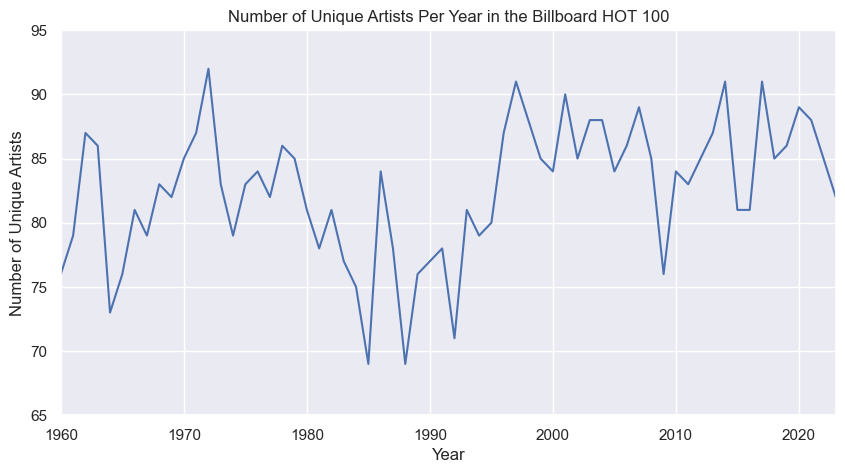

In [736]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=unique_artists_per_year, x='year', y='artist')
plt.title('Number of Unique Artists Per Year in the Billboard HOT 100')
plt.xlabel('Year')
plt.ylabel('Number of Unique Artists')
plt.ylim(65, 95)
plt.xlim(1960, 2023) 
plt.show()

The amount of unique artist each year stays within a certain range with a slight decrease in the 80s and rising again in the 90s. We can see that there has never been a year with 100% unique artists

#### **4.1.2 Most Frequent Artists Each Decade**

In [739]:
# Create a decade column
cleaned_df['decade'] = (cleaned_df['year'] // 10) * 10

# Group by decade and artist, and count the occurrences
artist_counts = cleaned_df.groupby(['decade', 'artist']).size().reset_index(name='count')

# Identify the most frequent artist for each decade
most_frequent_artists = artist_counts.loc[artist_counts.groupby('decade')['count'].idxmax()].reset_index(drop=True)

# Print the Dataframe
most_frequent_artists

,decade,artist,count
0,1960,The Beatles,23
1,1970,Bee Gees,12
2,1980,Madonna,18
3,1990,Mariah Carey,19
4,2000,Kelly Clarkson,13
5,2010,Drake,16
6,2020,Morgan Wallen,13


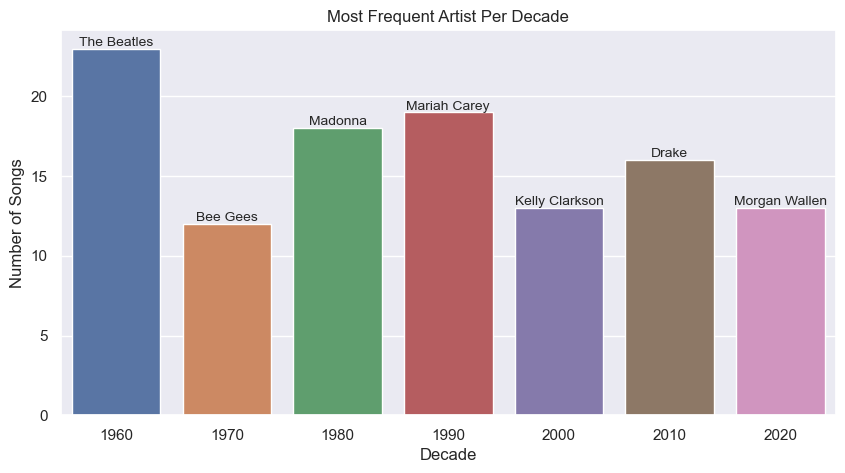

In [684]:
# Plot the most frequent artists per decade
plt.figure(figsize=(10, 5))
sns.barplot(data=most_frequent_artists, x='decade', y='count')
for i in range(len(most_frequent_artists)):
    plt.text(i, most_frequent_artists['count'][i], most_frequent_artists['artist'][i], 
             ha='center', va='bottom', fontsize=10)
plt.title('Most Frequent Artist Per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.show()

Overall, the chart above shows that different artists that have been the most frequents in the chart, indicating changes in musical trends and preferences over time. The number of songs each had on the top 100  also shows the varying levels of dominance and influence they had within their respective decades.

#### **4.1.3 Most Frequent Artist in the Top 10 Each Decade**

Now, lets do the analysis but with artist ranking in the top 10 each year

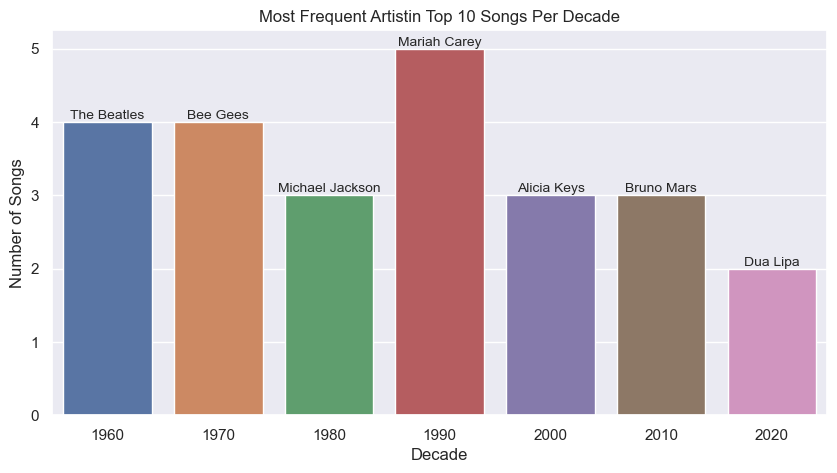

In [687]:
# Filter for top 10 songs in each year
top_10_df = cleaned_df[cleaned_df['rank'] <= 10]

# Count the frequency of each artist in the top 10 songs per decade
top_10_artists = top_10_df.groupby(['decade', 'artist']).size().reset_index(name='count')

top_10_frequent_artists = top_10_artists.loc[top_10_artists.groupby('decade')['count'].idxmax()].reset_index(drop=True)

# Plot the most frequent artists per decade
plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_frequent_artists, x='decade', y='count')
for i in range(len(top_10_frequent_artists)):
    plt.text(i, top_10_frequent_artists['count'][i], top_10_frequent_artists['artist'][i], 
             ha='center', va='bottom', fontsize=10)
plt.title('Most Frequent Artistin Top 10 Songs Per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.show()

#### **4.1.4 Conclusion**
The analysis reveals key insights in artist dominance and diversity. Each decade has seen certain artist consistently be in the top for a whole decade. While the number of unique artists per year has varied, the industry consistently showcases an evolving mix of artists and an ongoing evolution

### **4.2 Song Lenght Analysis**

Our objective for this sections will be to analyze the duration of songs over time and understand how the average song length has evolved. We want to find out if there is any relation between a song's length and the success of the track.

#### **4.2.1 Average Song Duration**


C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


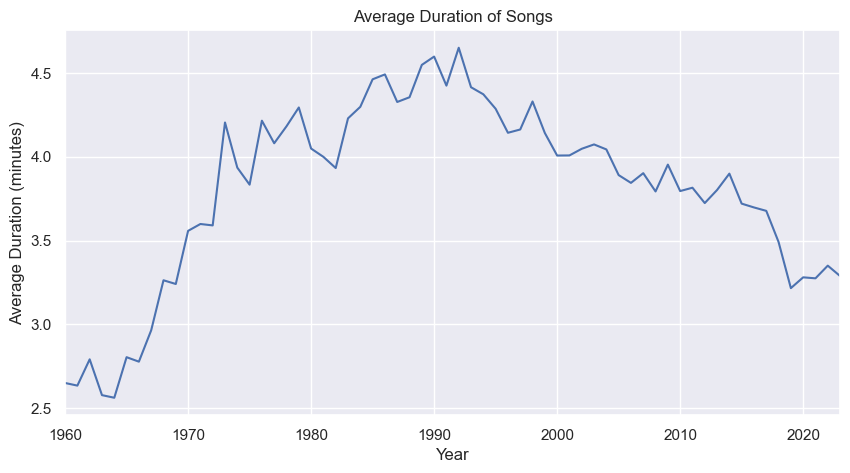

In [690]:
# Convert duration from milliseconds to minutes
cleaned_df['duration_min'] = cleaned_df['duration_ms'] / 60000

# Calculate the average duration per year
average_duration = cleaned_df.groupby('year')['duration_min'].mean().reset_index()

# Create line plot to visualize the data and trends over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=average_duration, x='year', y='duration_min')
plt.title('Average Duration of Songs')
plt.xlabel('Year')
plt.ylabel('Average Duration (minutes)')
plt.xlim(1960, 2023)
plt.show()

The graph above shows the averasge duration of songs in the Billboard Hot 100 each year. In the 60s we can see that songs typically had an average length of around 3 minutes having a heavy influence of rock and roll. During the 70s the average duration steadily increased to around 4 minutes influenced by genres like disco and rock. This upward trend continued into the 80s peaking at over 4.5 minutes. From the 90s to the 2000s, the average song length remained stable. However, in the latest years, there has been a decline, dropping to aprox 3.5 minutes. This trend may be driven by the rise of streaming platforms and changes in listening habits and content favouring shorter tracks

#### **4.2.2 Song Duration Distribution**

Now that we have seen the average duration of each song each year, we can dive into the average length of songs to find the the most common duration for a song.

C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


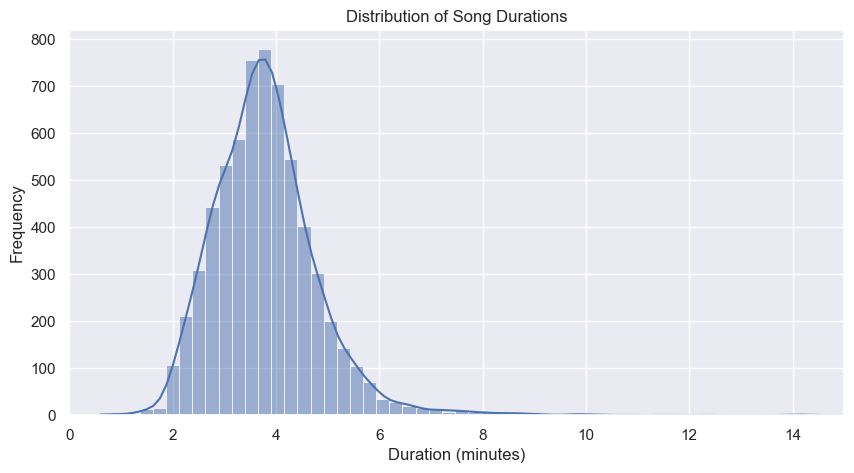

In [693]:
# Plot the histogram
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_df['duration_min'], bins=100, kde=True)
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, 15)
plt.show()

The average song duration is between 3 and 4.5 minutes. We can see that more than 2100+ songs are within this range. This could suggest that tracks that are between 3 and 4.5 minutes are more likely to become famous and be part of the top hot 100.
Additionally, there are fewer songs with very short or very long durations, highlighting a general preference for songs within the 3 to 4-minute range.

### **4.3 Energy**
For this section, we will analyze the change in energy levels over time to see if there is a trend change. We will also delve into the correlation between a song's energy level and its rank on the Billboard Hot 100. By exploring this relationship, we want to understand if higher energy levels correlate to better chart performance.


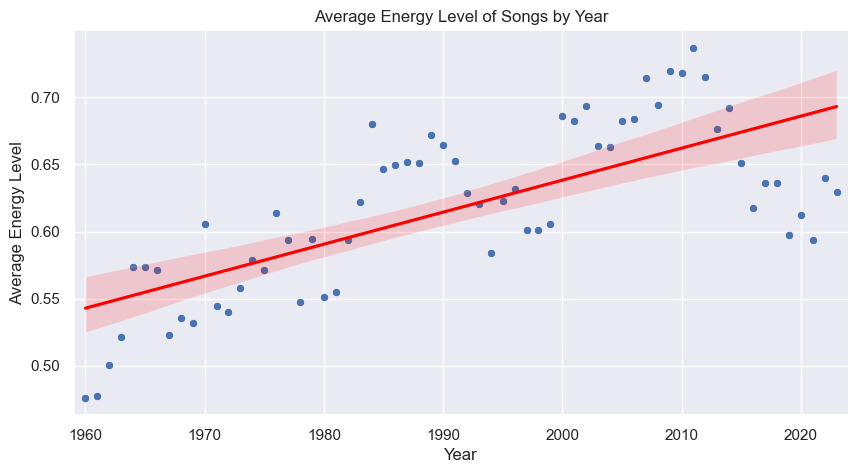

In [697]:
# Calculate the average energy per year
average_energy_per_year = cleaned_df.groupby('year')['energy'].mean().reset_index()

# Plot the scatter plot with a trend line for average energy of top-ranked songs by year
plt.figure(figsize=(10, 5))
sns.scatterplot(data=average_energy_per_year, x='year', y='energy')
sns.regplot(data=average_energy_per_year, x='year', y='energy', scatter=False, color='red')
plt.title('Average Energy Level of Songs by Year')
plt.xlabel('Year')
plt.ylabel('Average Energy Level')
plt.xlim(1959, 2024)
plt.show()

The scatter plot above shows a clear upward trend in the energy levels of songs in the top 100 over the years. In the 60s, the average energy level was around 0.50 to 0.55 and by the 2020s, this average has increased to 0.65 - 0.70. This suggests that over the decades, songs with higher energy levels have become more prevalent and popular. The increasing energy levels demonstrate a change in musical preferences towards more intense and active songs in popular music.

#### **4.3.1 Energy for the Top 10 and last 10 songs**

To further explore this, we will compare the energy levels of the top 10 songs with the last 10 songs each year. This analysis help us identify any significant differences in energy levels between the highest and lowest-ranked songs on the chart.

C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

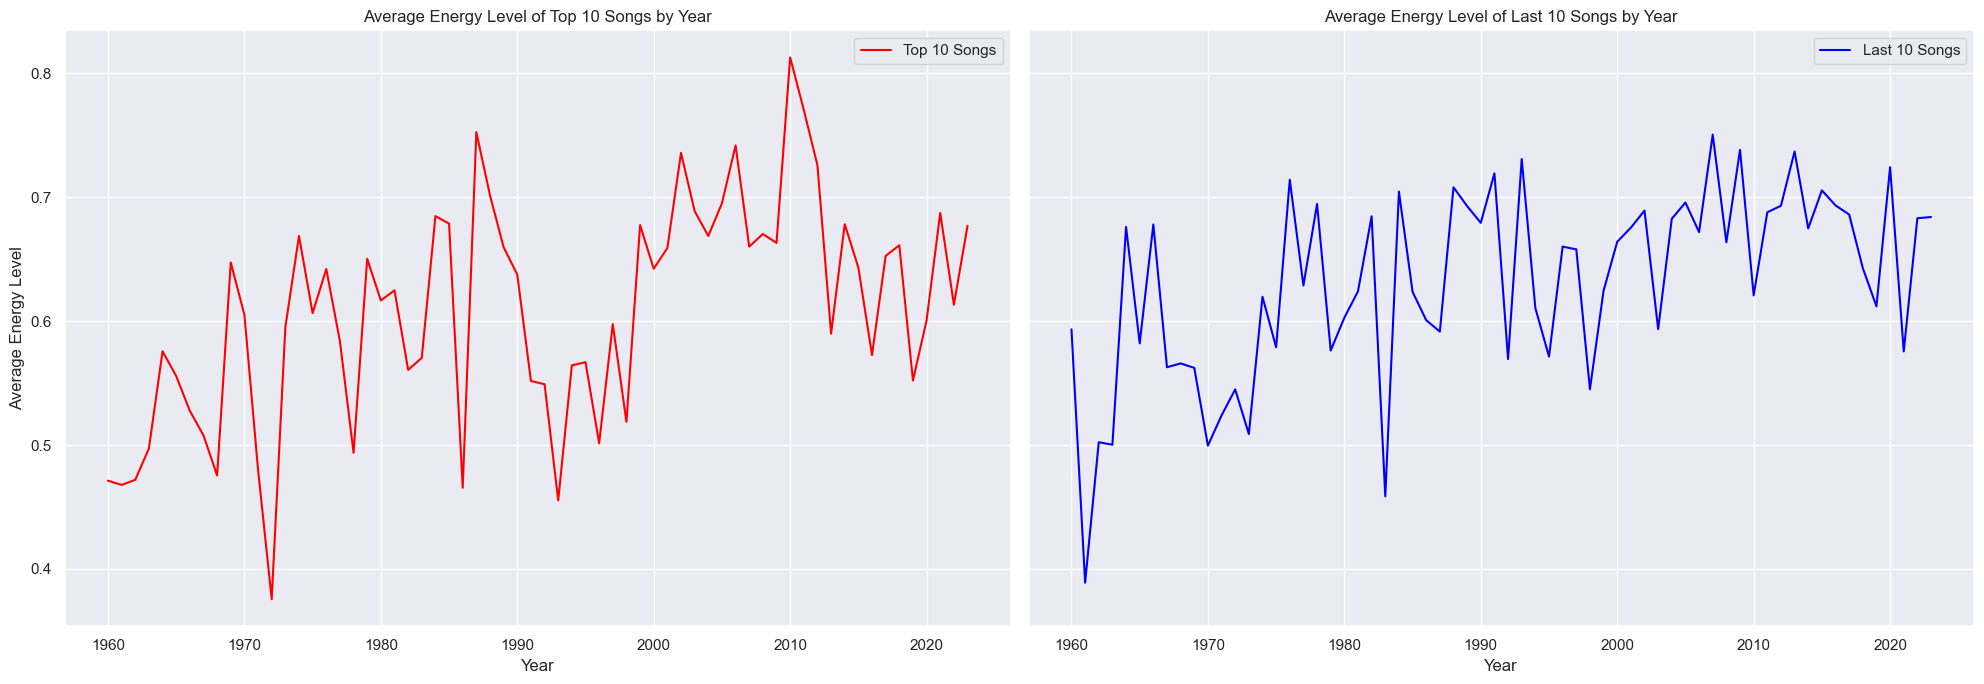

In [700]:
# Filter for top 10 and last 10 songs
top_10_songs = cleaned_df[cleaned_df['rank'] <= 10]
last_10_songs = cleaned_df[cleaned_df['rank'] > 90]

# Calculate the average energy per year for top 10 and last 10 songs
average_energy_top_10 = top_10_songs.groupby('year')['energy'].mean().reset_index()
average_energy_last_10 = last_10_songs.groupby('year')['energy'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Plot the line plot for top 10 songs
sns.lineplot(ax=axes[0], data=average_energy_top_10, x='year', y='energy', label='Top 10 Songs', color='red')
axes[0].set_title('Average Energy Level of Top 10 Songs by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Energy Level')
axes[0].legend()

# Plot the line plot for last 10 songs
sns.lineplot(ax=axes[1], data=average_energy_last_10, x='year', y='energy', label='Last 10 Songs', color='blue')
axes[1].set_title('Average Energy Level of Last 10 Songs by Year')
axes[1].set_xlabel('Year')
axes[1].legend()

plt.tight_layout()
plt.show()

From the graph above, we can see there is no relation between energy and the position a song will have on the charts. It stills display the upward trend of energy overtime.

#### **4.3.2 Energy vs Danceability**
Lets analyze the relationship between the energy of a song with its danceability value

C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


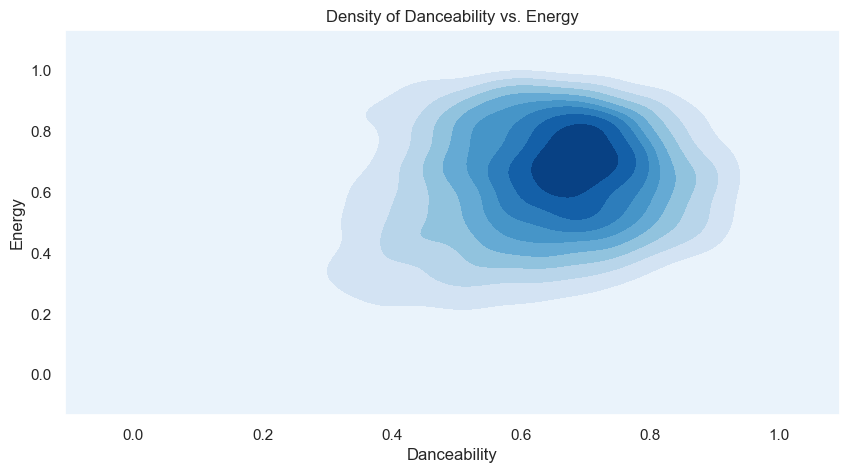

In [703]:
# KDE plot for danceability vs. energy
plt.figure(figsize=(10, 5))
sns.kdeplot(data=cleaned_df, x='danceability', y='energy', cmap='Blues', fill=True, thresh=0)
plt.title('Density of Danceability vs. Energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()

The plot shows that the majority of popular songs have moderate to high danceability levels. This suggests that songs with higher energy and danceability are more likely to achieve popularity, indicating a preference for lively and more rythmic songs. 
What we can take from this is that energetic and danceable music has been a consisten characteristic of popular songs over the decades

### **4.4 Loudness overtime**

With the advancement of technology and changes in the ways people listen to music, the Loudness of a track plays a crucial role. Lets dive into this attribute and see what trends we can find


C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cleme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


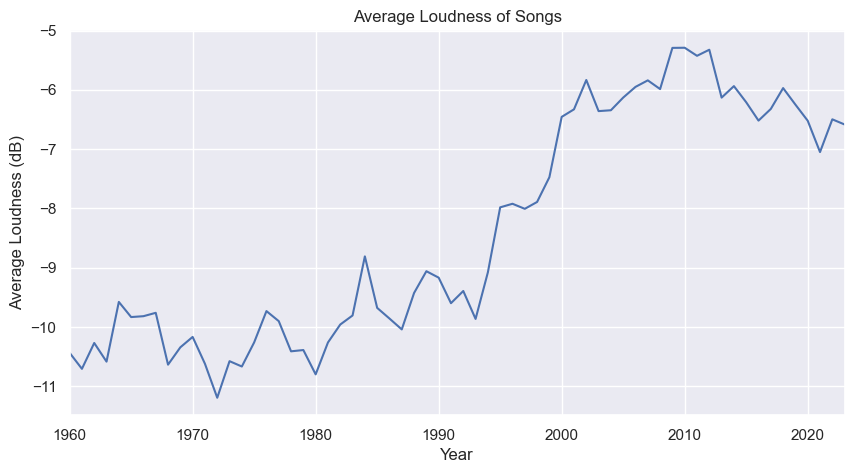

In [707]:
# Calculate the average loudness per year
average_loudness_per_year = cleaned_df.groupby('year')['loudness'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 5))
sns.lineplot(data=average_loudness_per_year, x='year', y='loudness')
plt.title('Average Loudness of Songs')
plt.xlabel('Year')
plt.ylabel('Average Loudness (dB)')
plt.xlim(1960, 2023)
plt.show()

#### **4.4.1 Conclusion**

It is clear from the graph above that from the 80s there is a significant increase in loudness. According to this article 'https://www.soundguys.com/the-loudness-war-51513/' we can attribute this trend to the 'loudness war. The loudness war aludes to the trend of increasing the overall volume of music recordings, which started in the late 80s and became quite present in the 90s. The aim was to make songs sound louder and more impactful when played on the radio to catch people's attention.

This brought changes in music production techniques as the end goal was to make music sound louder and impactful. The slight decrease in recent years suggest a shift towards more dynamic range in music production as more people have access to recording equipment, thus bringing a more diverse set of production styles.

### **4.5 Valence & Mode**

Valence is a measure that describes the musical positiveness conveyed by a track. Songs with a high valence sound more positive (happy, cheerful, euphoric), while songs with low valence sound more negative (sad, depressed, angry)

The mode indicates whether a song is in a major or minor key. By examining these attributes, we aim to understand how the emotional tone and key of a song are related

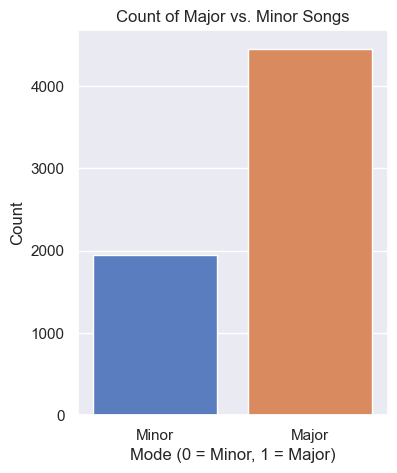

In [710]:
# Count the occurrences of major and minor modes
mode_counts = cleaned_df['mode'].value_counts()

# Plot the count of major vs. minor songs
plt.figure(figsize=(4, 5))
sns.barplot(x=mode_counts.index, y=mode_counts.values, palette='muted')
plt.title('Count of Major vs. Minor Songs')
plt.xlabel('Mode (0 = Minor, 1 = Major)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Minor', 'Major'])
plt.show()

This graph shows that songs with major keys are the most popular in the chart.

Lets create a violin plot so we can see the distribution of valence values for songs in major and minor key over time;

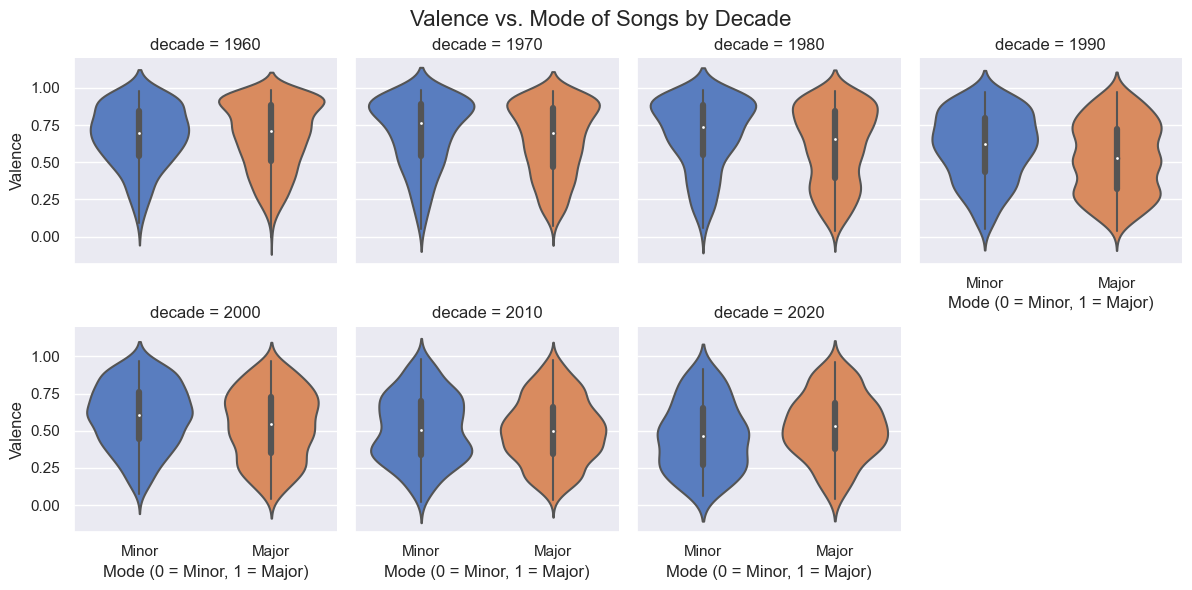

In [680]:
# Plot the relationship between valence and mode for each decade using facetgrid with violin plots
g = sns.FacetGrid(cleaned_df, col="decade", col_wrap=4, height=3, sharey=True)
g.map(sns.violinplot, 'mode', 'valence', order=[0, 1], palette='muted', split=False)
g.set_xticklabels(['Minor', 'Major'])
g.set_axis_labels('Mode (0 = Minor, 1 = Major)', 'Valence')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Valence vs. Mode of Songs by Decade', fontsize=16)
plt.show()

While there is no clear relationship between a song's key and its valence, a significant shift in the emotional tones of songs over the years is evident. In the earlier decades, songs generally had higher valence values, indicating a more positive emotional tone. However, this trend starts to decline in the later decades, suggesting that modern songs tend to convey more negative emotions. This evolution highlights a shift in the emotional landscape of popular music over time.
What could be the reason for this landscape change?

### **4.6 Acousticness**
Acousticness is a value that measures the confidence that a track is acoustic. With the music production and recording landscape having gone through several changes over the past decades(use of live instrument to record to the rise of digital recording, synthesizers and drum machines) we aim to explore how the technological shifts have influenced the music industry.

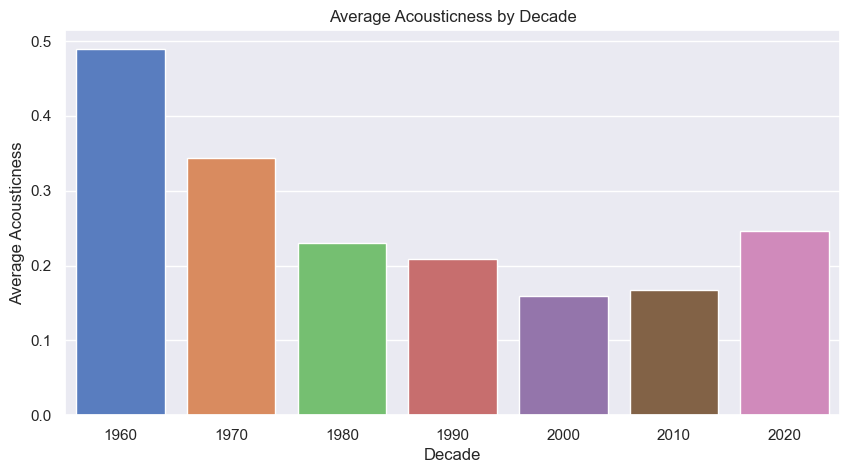

In [713]:
average_acousticness_by_decade = cleaned_df.groupby('decade')['acousticness'].mean().reset_index()

# Plot the average acousticness by decade
plt.figure(figsize=(10, 5))
sns.barplot(data=average_acousticness_by_decade, x='decade', y='acousticness', palette='muted')
plt.title('Average Acousticness by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Acousticness')
plt.show()

The barplot above indicates that there has been a steady decrease in the use of live instruments to record music from the 60s to the 2000s with a slight increase in recent years.

### **4.7 Key and Tempo**

Lets analyze the most popular chord and tempo used in the chart (top 10)

In [717]:
# Calculate the average tempo for the top 10 songs each year
average_tempo = top_10_songs.groupby('year')['tempo'].mean().reset_index()

# Calculate mean and standard deviation of the average tempos
mean_tempo = average_tempo['tempo'].mean()
std_tempo = average_tempo['tempo'].std()

# Print the results
print(f'Mean Tempo: {mean_tempo} BPM')
print(f'Standard Deviation of Tempo: {std_tempo} BPM')

Mean Tempo: 117.5366578125 BPM
Standard Deviation of Tempo: 7.17340167071814 BPM


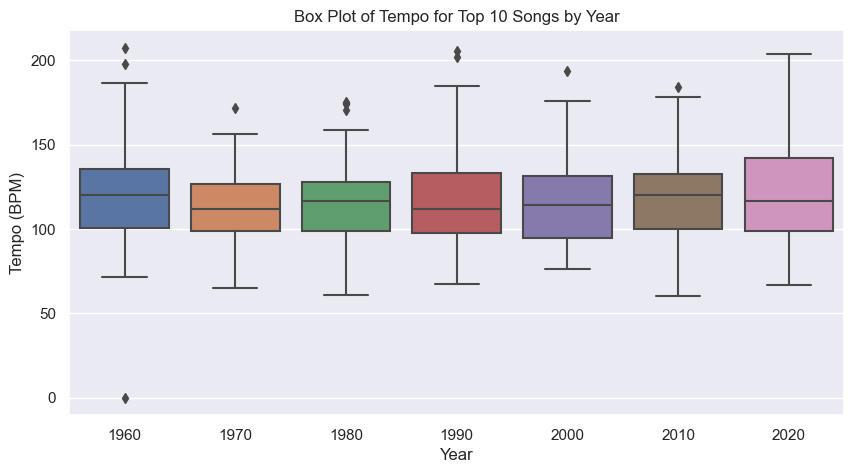

In [719]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=top_10_songs, x='decade', y='tempo')
plt.title('Box Plot of Tempo for Top 10 Songs by Year')
plt.xlabel('Year')
plt.ylabel('Tempo (BPM)')
plt.show()

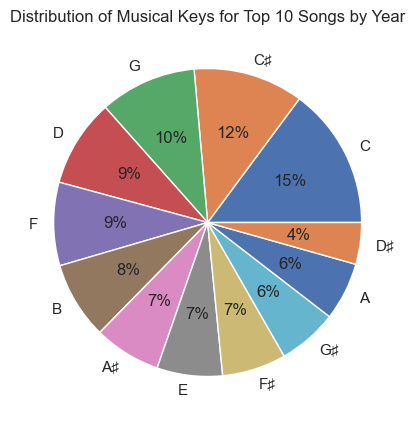

In [725]:
# Calculate the count for each musical key
key_counts = top_10_songs['key'].value_counts().reset_index()
key_counts.columns = ['key', 'count']

# Map key numbers to musical key names
key_map = {
    0: 'C',
    1: 'C♯',
    2: 'D',
    3: 'D♯',
    4: 'E',
    5: 'F',
    6: 'F♯',
    7: 'G',
    8: 'G♯',
    9: 'A',
    10: 'A♯',
    11: 'B'
}
key_counts['key'] = key_counts['key'].map(key_map)

# Plot the pie chart
plt.figure(figsize=(5, 5))
plt.pie(key_counts['count'], labels=key_counts['key'], autopct='%.0f%%')
plt.title('Distribution of Musical Keys for Top 10 Songs by Year')
plt.show()

#### **Following the insights extracted from our analysis, a song that last between 3 and 4 minutes long, has a tempo between 110BPM and 121BPM, uses the chord C and it is in a major mode will have better prospect of being in the charts and being sucessful**


## **5 Summary**

### **5.1 Conclusions**
The exploratory analysis of the combined dataset (Billboard Year-End Hot 100 & Spotify Attributes) has provided valuable insights into what contributes to a song's success and how trends change over time. We could observe the impact of technological advancements and social changes in the music industry as well as how artist approach their compositions.

Given that we have explored the dataset in a more general and high level way, we are yet to delve into each individual artist characteristics. This sets the way for further exploratory analysis of the dataset, it demonstrates how the analysis we could perform are powerful and vast.



## **6 References and Resources**

### **6.1 References**

- [1] TurnMeUp.org - The original Loudness War website. Lots and lots and lots of links !
- [2] 10 Cool Inventions From the 1980s By: Jonathan Strickland & Wesley Fenlon https://science.howstuffworks.com/innovation/inventions/5-cool-inventions-from-the-1980s.htm

### **6.2 Resources**
- [1] Billboard Hot 100 Wikipedia https://en.wikipedia.org/wiki/Billboard_Hot_100
- [2] Spotipy Documentation https://spotipy.readthedocs.io/en/2.24.0/
- [3] Spotify Web API https://developer.spotify.com/documentation/web-api
- [4] Scrape Wikipedia in Python - Ultimate Tutorial https://crawlbase.com/blog/scrape-wikipedia/
- [5] Seaborn Example Gallery https://seaborn.pydata.org/examples/index.html
- [6] Getting started with Web API https://developer.spotify.com/documentation/web-api/tutorials/getting-started
- [7] How To Concatenate Two or More Pandas DataFrames? https://www.geeksforgeeks.org/how-to-concatenate-two-or-more-pandas-dataframes/
- [8] Data cleaning is the process of identifying and removing errors from data. Don Hall Avatar, June 3 2024 https://technologyadvice.com/blog/information-technology/data-cleaning/
- [9] Wikipedia license https://en.wikipedia.org/wiki/Wikipedia:Text_of_the_Creative_Commons_Attribution-ShareAlike_4.0_International_License
- [10] Spotify API Policy https://developer.spotify.com/policy

#### Written by **Clemente Scaravilli**